In [1]:
import os
import sys
import numpy as np
import csv
from collections import Counter
import matplotlib.pyplot as plt

sys.path.append("../../..")

from pyopensn.mesh import FromFileMeshGenerator, PETScGraphPartitioner
from pyopensn.xs import MultiGroupXS
from pyopensn.aquad import GLCProductQuadrature2DXY
from pyopensn.solver import DiscreteOrdinatesProblem, PowerIterationKEigenSolver
from pyopensn.logvol import LogicalVolume, RCCLogicalVolume
from pyopensn.fieldfunc import *
from pyopensn.context import UseColor, Finalize

UseColor(False)

In [2]:
casename = '2L'
h5_name = '2l'

## Import Mesh Obj

In [3]:
mesh_filepath = 'lattice_'+casename+'.obj'
meshgen = FromFileMeshGenerator(
    filename=mesh_filepath,
    partitioner=PETScGraphPartitioner(type='parmetis')
)

grid = meshgen.Execute()
grid.ExportToPVTU('mesh_2A')

OpenSn version 0.0.1
2025-04-29 23:58:15 Running OpenSn with 1 processes.

[0]  FromFileMeshGenerator: Generating UnpartitionedMesh
[0]  Making Unpartitioned mesh from wavefront file lattice_2L.obj
[0]  Max material id: 15
[0]  Done checking cell-center-to-face orientations
[0]  00:00:00.9 Establishing cell connectivity.
[0]  00:00:00.9 Vertex cell subscriptions complete.
[0]  00:00:00.9 Surpassing cell 1004 of 10040 (10%)
[0]  00:00:00.9 Surpassing cell 2008 of 10040 (20%)
[0]  00:00:00.9 Surpassing cell 3013 of 10040 (30%)
[0]  00:00:00.9 Surpassing cell 4016 of 10040 (40%)
[0]  00:00:00.9 Surpassing cell 5020 of 10040 (50%)
[0]  00:00:00.9 Surpassing cell 6025 of 10040 (60%)
[0]  00:00:00.9 Surpassing cell 7029 of 10040 (70%)
[0]  00:00:00.9 Surpassing cell 8032 of 10040 (80%)
[0]  00:00:00.9 Surpassing cell 9036 of 10040 (90%)
[0]  00:00:00.9 Surpassing cell 10040 of 10040 (100%)
[0]  00:00:00.9 Establishing cell boundary connectivity.
[0]  00:00:00.9 Done establishing cell connect

## Import OpenMC Cross Sections

In [4]:
xs_filepath = 'mgxs_casl_'+h5_name+'/mgxs_'+h5_name+'_one_eighth_SHEM-361.h5'
xs_dict = {}
xs_list = []

h5_mat_names = ['coated_fuel_clad',
		'coating',
		'normal_fuel',
		'normal_fuel_clad',
		'normal_fuel_gap',
		'coated_fuel',
		'coated_fuel_gap',
		'gt-clad',
		'gt-water-in',
		'gt-water-out',
		'it-clad',
		'it-water-in',
		'it-water-out',
		'normal_fuel_moderator',
		'coated_fuel_moderator',
		'water_outside'
]




for name in h5_mat_names:
    xs_dict[name] = MultiGroupXS()
    xs_dict[name].LoadFromOpenMC(xs_filepath, name, 294.0)
    xs_list = np.append(xs_list,xs_dict[name])

block_ids = [i for i in range(0,len(xs_list))]

scat_order = 3 #xs_list[0].scattering_order

[0]  Reading OpenMC cross-section file "mgxs_casl_2l/mgxs_2l_one_eighth_SHEM-361.h5"
[0]  mgxs_casl_2l/mgxs_2l_one_eighth_SHEM-361.h5 cross-section data evaluated at 294K
[0]  *** WARNING ***  Estimating absorption from the transfer matrices.
[0]  *** WARNING ***  Negative absorption cross section encountered in group 0 when estimating from the transfer matrices
[0]  *** WARNING ***  Negative absorption cross section encountered in group 1 when estimating from the transfer matrices
[0]  *** WARNING ***  Negative absorption cross section encountered in group 2 when estimating from the transfer matrices
[0]  *** WARNING ***  Negative absorption cross section encountered in group 3 when estimating from the transfer matrices
[0]  *** WARNING ***  Negative absorption cross section encountered in group 4 when estimating from the transfer matrices
[0]  *** WARNING ***  Negative absorption cross section encountered in group 5 when estimating from the transfer matrices
[0]  Reading OpenMC cross

## Create Quadratures

In [5]:
pquad = GLCProductQuadrature2DXY(32, 4)

In [6]:
block_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

## Physics

In [7]:
num_groups = 361
#num_groups = 361
# Constraints: "classic_richardson", "petsc_richardson", "petsc_gmres", "petsc_bicgstab"
group_sets = [{
            "groups_from_to": (0, num_groups - 1),
            "angular_quadrature": pquad,
            "angle_aggregation_num_subsets": 1,
            "inner_linear_method": "petsc_gmres",
            "l_abs_tol": 1.0e-6,
            "l_max_its": 300,
            #"gmres_restart_interval": 30
            }]

group_sets = [{
            "groups_from_to": (0, num_groups - 1),
            "angular_quadrature": pquad,
            "angle_aggregation_num_subsets": 1,
            "inner_linear_method": "classic_richardson",
            "l_abs_tol": 1.0e-1,
            "l_max_its": 5,
            #"gmres_restart_interval": 30
            }]

# fix this when automating it stops breaking
bound_conditions = [
                        { 'name' : "xmin", 'type' : "reflecting" },
                        { 'name' : "xmax", 'type' : "reflecting" },
                        { 'name' : "ymin", 'type' : "reflecting" },
                        { 'name' : "ymax", 'type' : "reflecting" },
                        { 'name' : "zmin", 'type' : "reflecting" },
                        { 'name' : "zmax", 'type' : "reflecting" }
                        ]
# fix this when automating it stops breaking
xs_mapping = [
            {'block_ids' : [0],'xs' : xs_list[0]},
            {'block_ids' : [1],'xs' : xs_list[1]},
            {'block_ids' : [2],'xs' : xs_list[2]},
            {'block_ids' : [3],'xs' : xs_list[3]},
            {'block_ids' : [4],'xs' : xs_list[4]},
            {'block_ids' : [5],'xs' : xs_list[5]},
            {'block_ids' : [6],'xs' : xs_list[6]},
            {'block_ids' : [7],'xs' : xs_list[7]},
            {'block_ids' : [8],'xs' : xs_list[8]},
            {'block_ids' : [9],'xs' : xs_list[9]},
            {'block_ids' : [10],'xs' : xs_list[10]},
            {'block_ids' : [11],'xs' : xs_list[11]},
            {'block_ids' : [12],'xs' : xs_list[12]},
            {'block_ids' : [13],'xs' : xs_list[13]},
            {'block_ids' : [14],'xs' : xs_list[14]},
            {'block_ids' : [15],'xs' : xs_list[15]}
            ]
#xs_mapping = [
#            {'block_ids' : [0],'xs' : xs_list[0]},
#            {'block_ids' : [1],'xs' : xs_list[1]},
#            {'block_ids' : [2],'xs' : xs_list[2]},
#            {'block_ids' : [3],'xs' : xs_list[3]}
#            ]
#xs_mapping = [{'block_ids' : [0],'xs' : xs_list[0]}]

phys = DiscreteOrdinatesProblem(mesh=grid,
                                num_groups=num_groups,
                                groupsets= group_sets,
                                xs_map=xs_mapping
                                        )
phys.SetOptions(scattering_order=1, #scat_order,
                verbose_inner_iterations=True,
                verbose_outer_iterations=True,
                power_default_kappa=1.0,
                power_normalization=1.0,
                save_angular_flux=False,
                #write_restart_time_interval = 3660,
                #write_restart_path = "2A_restart/2A",
                boundary_conditions = bound_conditions
                                    )


In [8]:
k_solver = PowerIterationKEigenSolver(lbs_problem = phys,
                                      k_tol = 1.0e-8
                                     )
k_solver = PowerIterationKEigenSolver(lbs_problem = phys,
                                      k_tol = 1.0e-1
                                     )

In [9]:
k_solver.Initialize()

[0]  
[0]  Initializing LBS SteadyStateSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 1
[0]  Number of Groups    : 361
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0     1     2     3     4     5     6     7     8     9    10    11 
[0]     12    13    14    15    16    17    18    19    20    21    22    23 
[0]     24    25    26    27    28    29    30    31    32    33    34    35 
[0]     36    37    38    39    40    41    42    43    44    45    46    47 
[0]     48    49    50    51    52    53    54    55    56    57    58    59 
[0]     60    61    62    63    64    65    66    67    68    69    70    71 
[0]     72    73    74    75    76    77    78    79    80    81    82    83 
[0]     84    85    86    87    88    89    90    91    92    93    94    95 
[0]     96    97    98    99   100   101   102   103   104   105   106   107 
[0]    108   109   110   111   112   113   114   115   116   117   118 

In [9]:
k_solver.Execute()

[0]  
[0]  
[0]  ********** Solving groupset 0 with CLASSIC_RICHARDSON.
[0]  
[0]  Quadrature number of angles: 64
[0]  Groups 0 360
[0]  
[0]  00:01:11.6 WGS groups [0-360]: Iteration = 0     Point-wise change = 0.973841       Spectral-radius estimate = 0         
[0]  00:01:42.5 WGS groups [0-360]: Iteration = 1     Point-wise change = 1.13075        Spectral-radius estimate = 1.07755   
[0]  00:02:13.6 WGS groups [0-360]: Iteration = 2     Point-wise change = 41.5159        Spectral-radius estimate = 6.05933   
[0]  00:02:44.7 WGS groups [0-360]: Iteration = 3     Point-wise change = 5.56996        Spectral-radius estimate = 0.366284  
[0]  00:03:16.7 WGS groups [0-360]: Iteration = 4     Point-wise change = 36.1397        Spectral-radius estimate = 2.54722   
[0]  
[0]         Average sweep time (s):        18.8929
[0]         Sweep Time/Unknown (ns):       20.8978
[0]         Number of unknowns per sweep:  904059520
[0]  
[0]  00:03:16.7 AGS Iteration 0     Error Norm 9170.77     

In [16]:
keff = k_solver.GetEigenvalue()
fflist = phys.GetScalarFieldFunctionList()
#FieldFunctionGridBased.ExportMultipleToVTK(
#    [fflist[0]],
#    'test')

In [11]:
pitch = 1.26
num_cells = 17
half_water_gap = 0.04

def compute_cell_center(i, j):
    x_center = (i - 1) * pitch - (num_cells / 2) * pitch + half_water_gap
    y_center = (j - 1) * pitch - (num_cells / 2) * pitch + half_water_gap
    return x_center, y_center

# avoid_pairs = {
#     4  : [14, 4],
#     12 : [3, 6, 9, 15, 12],
#     3  : [6, 12, 9],
#     9  : [3, 6, 12, 15, 9],
#     14 : [14, 4],
#     15 : [6, 12, 9],
#     6  : [3, 6, 12, 9, 15]
# }
# 
# def should_avoid(i, j):
#     if i in avoid_pairs:
#         for value in avoid_pairs[i]:
#             if value == j:
#                 return True
#     
#     return False


In [12]:
your_files = os.getcwd()

def read_csv_to_2d_array(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        data = [row for row in reader]
    return np.asarray(data)

def count_frequencies(data):
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    print("cell name frequency:")
    total = 0
    for key, value in cell_frequencies.items():
        print(f'"{key}": {value}')
        total += value
    print("total: ",total)

    
csv_filename = 'FA_cell_names_1_family.csv'
csv_filepath = your_files+'/'+csv_filename

lattice_csv = read_csv_to_2d_array(csv_filepath)

count_frequencies(lattice_csv)

if lattice_csv.shape[0] != lattice_csv.shape[1]:
    raise Exception('CSV array of cell names is not square.')
    
csv_size = lattice_csv.shape[0] #size of the assembly 

cell name frequency:
"fu": 264
"gt": 24
"it": 1
total:  289


In [24]:
val_table = np.zeros([num_cells,num_cells])

fuel_xs = xs_dict["fuel"]
sig_f = np.array(fuel_xs.sigma_f)


for i in range(1,num_cells+1):
      for j in range(1,num_cells+1):
          if lattice_csv[i-1,j-1] == 'fu':
              x_center, y_center = compute_cell_center(i, j)
              my_lv = RCCLogicalVolume(r = 0.4060, x0 = x_center, y0 = y_center, z0 = -1.0, vz = 2.0)

              val = 0
              for g in range(0, num_groups):
                  ffi = FieldFunctionInterpolationVolume()
                  ffi.SetOperationType('sum')
                  ffi.SetLogicalVolume(my_lv)
                  ffi.AddFieldFunction(fflist[g])
                  ffi.Initialize()
                  ffi.Execute()
                  val_g = ffi.GetValue()
                  val += val_g * sig_f[g]
              val_table[i-1][j-1] = val

In [25]:
maxes = np.zeros([num_cells])
for i in range(0,num_cells):
    maxes[i] = max(val_table[:,i])
val_max = max(maxes)

In [19]:
np.savetxt("power.txt",val_table/val_max)
with open("keff.txt", "w") as file:
    file.write(str(keff))

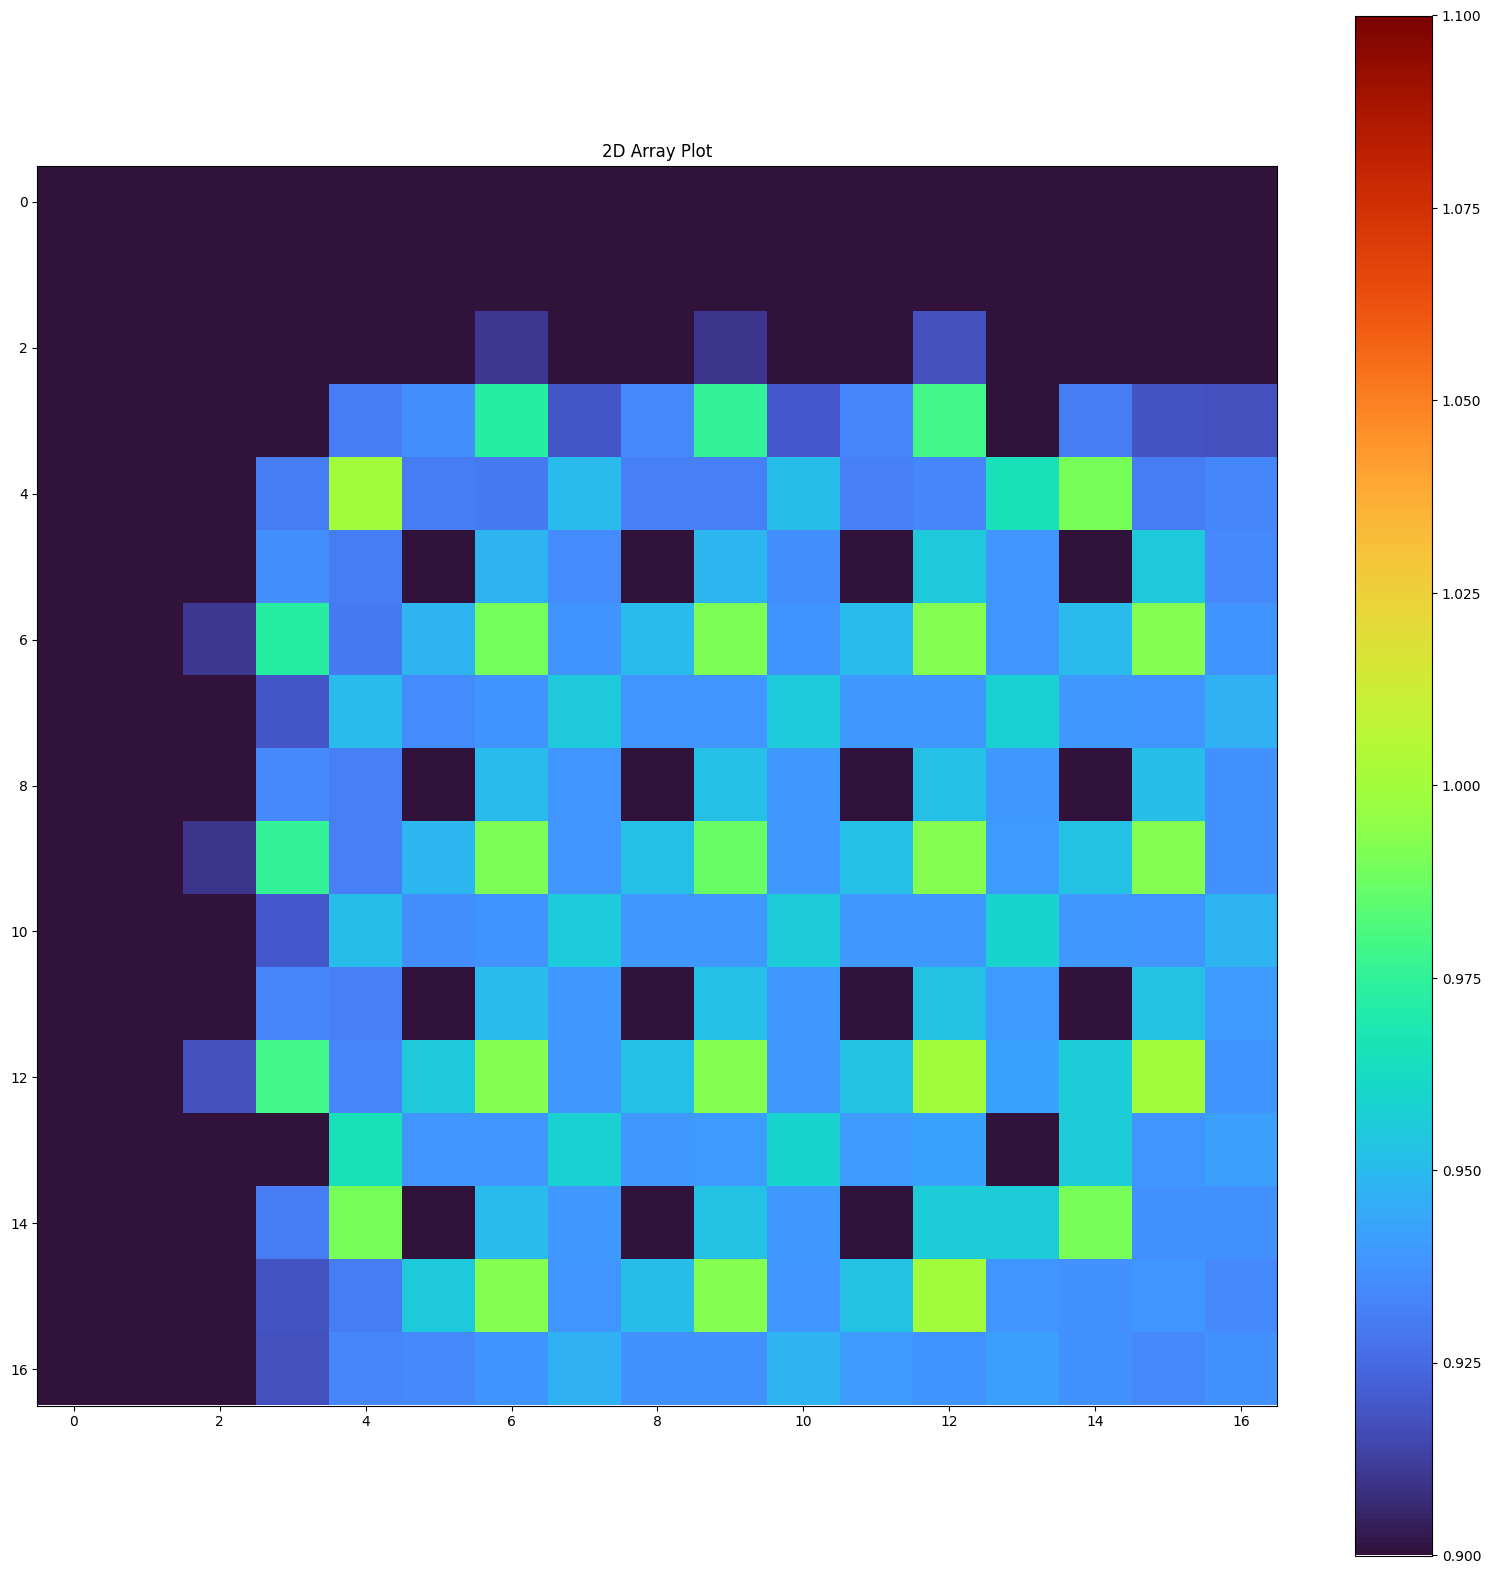

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(val_table/val_max, cmap='turbo')  # You can change the colormap if desired
plt.title('2D Array Plot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.clim([0.9,1.1])
plt.show()